In [54]:
%reload_ext autoreload
%autoreload 1
from model_files.model import MushroomClassifier
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import numpy as np
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18,ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import pytorch_lightning as ptl
from torchmetrics.classification import Accuracy
from torch.utils.data import Subset
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
%aimport model_files.model

In [3]:
BASE_FIG_SIZE=(8.5,5)

In [4]:
files=os.listdir("Mushrooms")
genuses = [file for file in files]
genus_data_count={}
for genus in genuses:
    pics=os.listdir(f"Mushrooms/{genus}")
    genus_data_count[genus]=len([pic for pic in pics])

In [5]:
genus_data_count

{'Boletus': 1073,
 'Cortinarius': 836,
 'Entoloma': 364,
 'Hygrocybe': 316,
 'Lactarius': 1563,
 'Russula': 1148,
 'Agaricus': 353,
 'Amanita': 750,
 'Suillus': 311}

<Axes: >

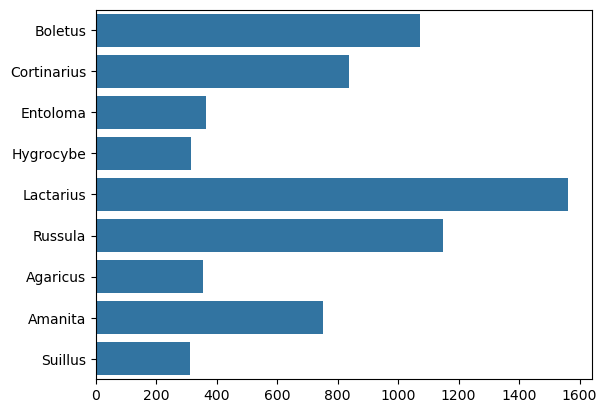

In [6]:
sns.barplot(genus_data_count,orient='y')

In [7]:
sizes = {}
for genus in genus_data_count.keys():
    sizes[genus] = pl.DataFrame(schema={"name":str, "height":int, "width":int, "channels":int})
    for img_name in os.listdir(f"Mushrooms/{genus}"):
        img = cv2.imread(f"Mushrooms/{genus}/{img_name}")
        height, width, channels = img.shape
        extend_df = pl.DataFrame(
            {"name": img_name, "height": height, "width": width, "channels": channels}
        )
        sizes[genus]=sizes[genus].extend(extend_df)

Premature end of JPEG file


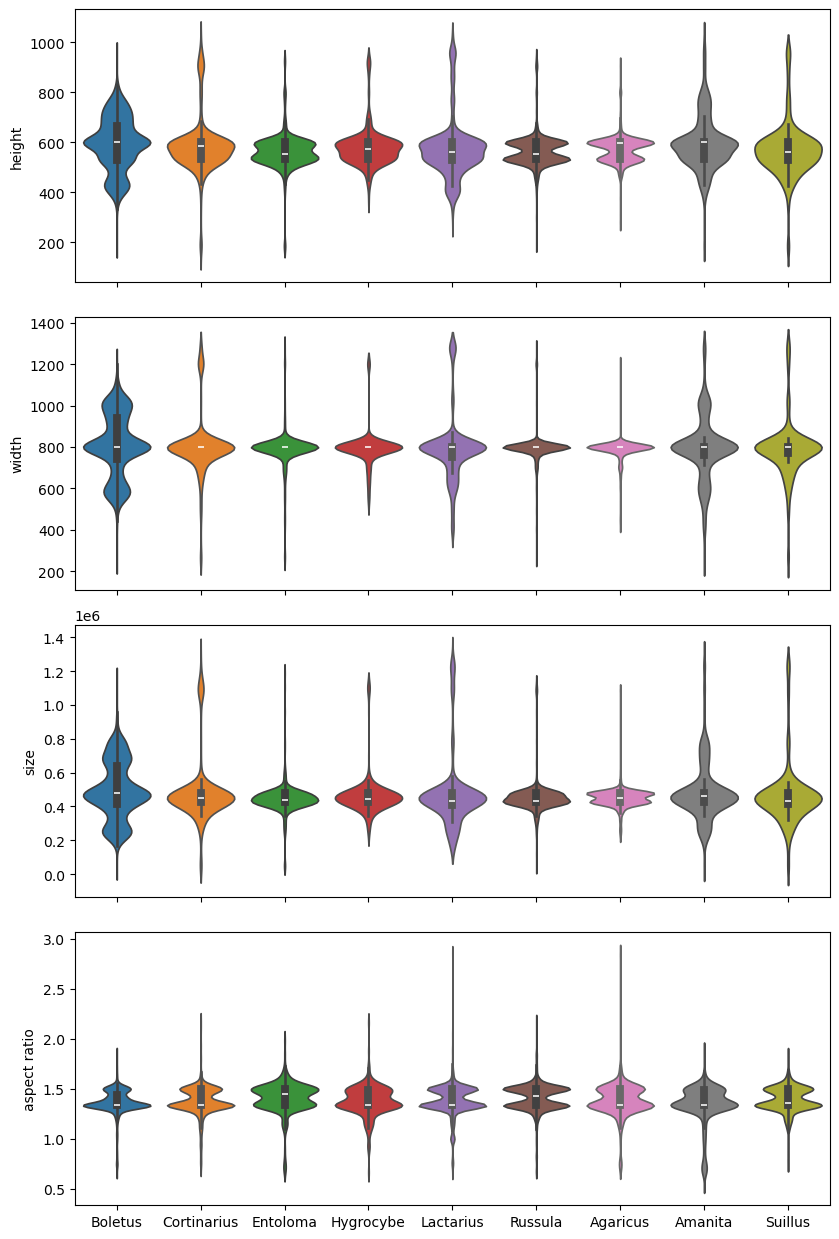

In [8]:
fig_sizes, ax_sizes = plt.subplots(
    4, 1, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2.5), sharex=True
)
for i, genus in enumerate(sizes.keys()):
    sns.violinplot(y=sizes[genus]["height"], x=i, ax=ax_sizes[0])
    sns.violinplot(y=sizes[genus]["width"], x=i, ax=ax_sizes[1])
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("height") * pl.col("width")).alias("size"))
        .to_series(),
        x=i,
        ax=ax_sizes[2],
    )
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("width") / pl.col("height")).alias("aspect ratio"))
        .to_series(),
        x=i,
        ax=ax_sizes[3],
    )

ax_sizes[3].set_xticks(ticks=np.arange(len(sizes)), labels=sizes.keys())
plt.tight_layout()
plt.show()

sizes

In [9]:
for i, genus in enumerate(sizes.keys()):
    channel_counts=sizes[genus]["channels"].value_counts()
    if len(channel_counts) >1:
        print(f"{genus} contains images with different channel number.")
    else:
        print(f" All {genus} images have {channel_counts['channels'][0]} channels")

 All Boletus images have 3 channels
 All Cortinarius images have 3 channels
 All Entoloma images have 3 channels
 All Hygrocybe images have 3 channels
 All Lactarius images have 3 channels
 All Russula images have 3 channels
 All Agaricus images have 3 channels
 All Amanita images have 3 channels
 All Suillus images have 3 channels


In [10]:
size_filter = []
for genus in sizes.keys():
    small_img_list = (
        sizes[genus]
        .filter((pl.col("height") < 224) | (pl.col("width") < 224))["name"]
        .to_list()
    )
    small_img_list = [f"Mushrooms/{genus}/{name}" for name in small_img_list]
    size_filter.extend(small_img_list)

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

Setting up train, validation and test data sets

In [12]:
def image_val(path):
    try:
        image=Image.open(path)
        image=image.resize((225,225))
        return True
    except:
        os.remove(path)
        return False

In [13]:
# Loading the data
dataset = datasets.ImageFolder(
    root="Mushrooms", transform=transform, is_valid_file=image_val
)
quality_image_idx = [
    i for i in range(len(dataset)) if dataset.imgs[i][0] not in size_filter
]
dataset = Subset(dataset, quality_image_idx).dataset
# Adding the samples to a numbered data frame
path_df = pl.DataFrame(dataset.samples, schema=["img", "class"])
path_df = path_df.with_columns(pl.Series(np.arange(len(path_df))).alias("id"))
# Getting a list of data point indexes for a shuffled and stratified split
train_idx, valid_test_idx = train_test_split(
    path_df, stratify=path_df["class"], test_size=0.4
)
train_idx = train_idx["id"].to_list()
valid_idx, test_idx = train_test_split(
    valid_test_idx, stratify=valid_test_idx["class"], test_size=0.5
)
valid_idx = valid_idx["id"].to_list()
test_idx = test_idx["id"].to_list()
# Subsets based on index
train_set = Subset(dataset, train_idx)
valid_set = Subset(dataset, valid_idx)
test_set = Subset(dataset, test_idx)
# Loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=5)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=5)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=5)

In [27]:
tb_logger = ptl.loggers.TensorBoardLogger()

In [50]:


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Choose the metric to monitor (e.g., 'val_loss')
    patience=5,            # Number of consecutive epochs without improvement
    mode='min',
    min_delta=0.001 ,
               # 'min' means training will stop when the monitored quantity stops decreasing
)

In [44]:
# shutil.rmtree('logs')

In [51]:
# Initialize the Lightning model
model = MushroomClassifier(num_classes=len(dataset.classes))

# Initialize a Lightning trainer
trainer = ptl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    callbacks=[early_stopping_callback],
    logger=tb_logger,
)  # Adjust max_epochs and gpus as needed

# Train the model
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Epoch 12: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, v_num=0]         


In [38]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 27397), started 0:00:09 ago. (Use '!kill 27397' to kill it.)

In [41]:
model.logger.call

In [59]:
model.metrics

AttributeError: 'MushroomClassifier' object has no attribute 'metrics'

In [60]:
results=trainer.test(model, dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  8.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7081161737442017
        test_loss            1.325825572013855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [65]:
results[-1]['test_loss']

1.325825572013855